# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
boston = pd.read_csv('boston_house_prices.csv', header=[1])


In [3]:
X = boston.drop(columns = 'MEDV')
y = boston["MEDV"]

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.887543443852714

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [6]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    squared_error = 0.0
    predictions = np.zeros(y.shape[0])
    squared_predictions = np.zeros(y.shape[0])
    cnt = np.zeros(y.shape[0])

    for _ in range(num_runs):
        indx = np.random.choice(np.arange(X.shape[0]), X.shape[0])
        X_bootstrapped = X.iloc[indx]
        y_bootstrapped = y[indx]

        out_of_bag = ~np.isin(np.arange(X.shape[0]), np.unique(indx))

        X_out_of_bag = X[out_of_bag]
        y_out_of_bag = y[out_of_bag]


        regressor.fit(X_bootstrapped, y_bootstrapped)
        y_pred = regressor.predict(X_out_of_bag)

        squared_error += np.sum((y_out_of_bag - y_pred) ** 2)

        predictions[out_of_bag] += y_pred
        squared_predictions[out_of_bag] += y_pred**2
        cnt[out_of_bag] += 1

        

    average_prediction = predictions / cnt
    average_squared_prediction = squared_predictions / cnt
    
    average_squared_error = squared_error / np.sum(cnt)

    bias = np.mean((average_prediction - y)**2)

    variance = np.mean(average_squared_prediction -  average_prediction ** 2)

    

    return bias, variance,  average_squared_error


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import GradientBoostingRegressor

In [8]:
lin_clf = LinearRegression()
r = compute_biase_variance(lin_clf, X, y)
print(f'For linear regression: bias={r[0]}, variance={r[1]}, error = {r[2]}')

For linear regression: bias=23.70504485881086, variance=0.9368389912785792, error = 24.70542833006508


In [9]:
tree = DecisionTreeRegressor()
t = compute_biase_variance(tree, X, y)
print(f'For descision tree: bias={t[0]}, variance={t[1]}, error = {t[2]}')

For descision tree: bias=10.624733418755579, variance=13.010975775594698, error = 23.673270403686434


In [10]:
forest = RandomForestRegressor()
f = compute_biase_variance(forest, X, y)
print(f'For random forest: bias={f[0]}, variance={f[1]}, error = {f[2]}')

For random forest: bias=10.577677760165287, variance=2.2799736113729514, error = 12.960724792405516


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Линейный модели очень простые, поэтому у них большое смещение, так как из-за своей простоты они дают не всегда точные предсказания и не подгонятются под обучаюшую выборку и низкий разброс, не сильно зависят от изменения обучающей выборки

Решающие деревья наоборот имеют низкое смещение, потому что может достичь идеального качества на обучающей выборке, но при этом большой разброс, потому что очень чувствительно к обучающей выборке

Случайный лес если брать композиции решающих деревьев, то смещение останется таким же, как у базовой модели, а разбрас уменьшится в n раз, если деревья некореллированы.

Полученные данные полностью подходят под рассуждения с лекции и хорошо их подтверждают

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.



In [11]:
lin_clf = BaggingRegressor(LinearRegression(), random_state=42)
r = compute_biase_variance(lin_clf, X, y)
print(f'For linear regression with bagging: bias={r[0]}, variance={r[1]}, error = {r[2]}')

For linear regression with bagging: bias=23.74333676471623, variance=1.057789177177295, error = 24.819025343592006


In [12]:
tree = BaggingRegressor(DecisionTreeRegressor(), random_state=42)
t = compute_biase_variance(tree, X, y)
print(f'For descision tree with bagging: bias={t[0]}, variance={t[1]}, error = {t[2]}')

For descision tree with bagging: bias=10.672500701742702, variance=3.4002631938397405, error = 14.069416689956125


In [13]:
forest =  BaggingRegressor(RandomForestRegressor(), random_state=42)
f = compute_biase_variance(forest, X, y)
print(f'For random forest with bagging: bias={f[0]}, variance={f[1]}, error = {f[2]}')

For random forest with bagging: bias=11.686934194618425, variance=1.400671116325033, error = 13.080546598008905


__Your answer here:__

В идеальном мире, где базовые модели не коррелируют между собой, разброс удалось бы уменьшить в N раз.

Для линейной регрессии после применения беггинга ничего особо не поменялось, потому что базовые модели сильно коррелируют между собой.

Для решающего дерева разброс уменьшился в несколько раз, потому что модели слабо коррелируют друг с дургом, поэтому удалось добиться хорошего улучшения, а разброс остался таким же как до бэггинга, что согласуется с теорией с лекций.

Для случайного леса разброс и так был достаточно маленьким до бэггинга, и после беггинга смещение немного выросо, а разброс немного уменьшился

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [16]:
def plot_predictions(regressor, X, y, ax , num_runs=100, num_test_objects=10, title=''):
    test_indices = np.random.choice(len(X), size=num_test_objects, replace=False)
    train_indices = np.setdiff1d(np.arange(len(X)), test_indices)
    
    X_test, y_test = X.iloc[test_indices], y[test_indices]
    X_train, y_train = X.iloc[train_indices], y[train_indices]
    
    predictions = np.zeros((num_test_objects, num_runs))
    
    for j in range(num_runs):
        indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap  = X_train.iloc[indices]
        y_bootstrap = y_train.iloc[indices]
        
        
        regressor.fit(X_bootstrap, y_bootstrap)
        predictions[:, j] = regressor.predict(X_test)
    
    sns.set(style='whitegrid')
    
    df_predictions = pd.DataFrame(predictions.T, columns=[f'{i}' for i in range(num_test_objects)])
    df_predictions = df_predictions.stack().reset_index()
    df_predictions.columns = ['Run', 'Test Object', 'Prediction']
    
    sns.scatterplot(data=df_predictions, x='Test Object', y='Prediction', hue='Run', palette='Blues', alpha=0.3, ax = ax)
    sns.scatterplot(data=pd.DataFrame({'Test Object': range(num_test_objects), 'True Value': y_test}), x='Test Object', y='True Value', color='black', marker='o', s=70, ax = ax)
    
    ax.set_xlabel('Test Objects')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.legend().remove()




__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

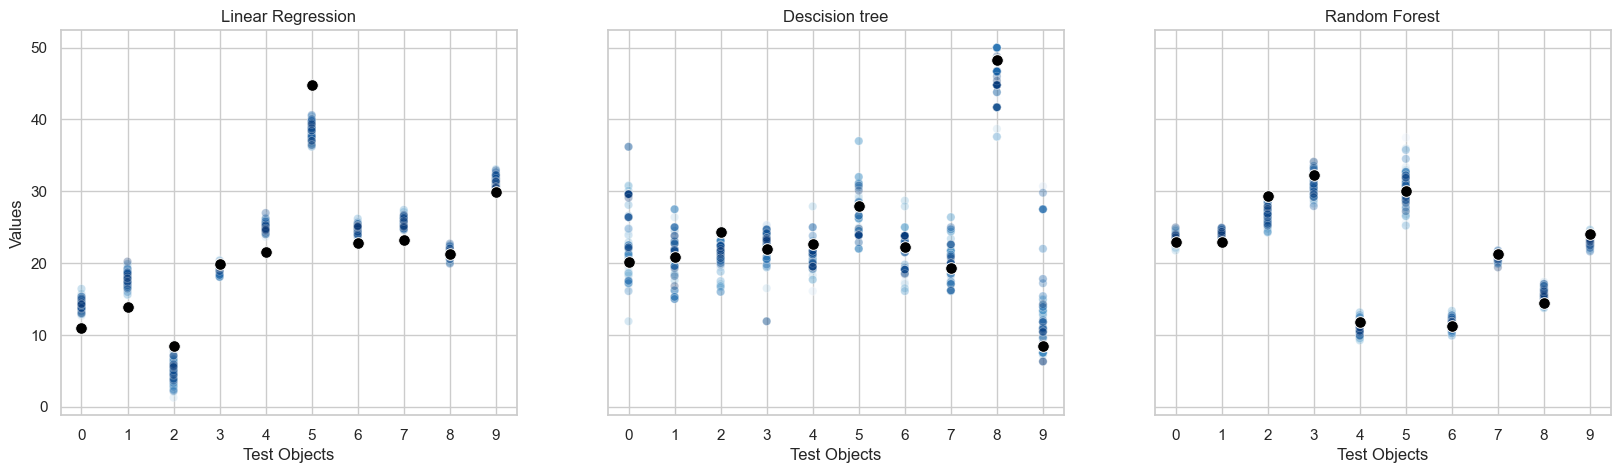

In [19]:
lin_clf = LinearRegression()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()
fig, ax = plt.subplots(1, 3, sharey=True,figsize=(20, 5))
plot_predictions(lin_clf, X, y, title='Linear Regression', ax=ax[0])
plot_predictions(tree ,X, y, title='Descision tree', ax=ax[1])
plot_predictions(forest, X, y ,title='Random Forest', ax=ax[2])


__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Линейная регрессия часто дает сильное смещение от реальных ответов и при этом разброс достаточно низкий, что совпадает с полученными до этого ответами.

Решающее дерево имеет гораздо больший разброс, потому что точки словно растянуты, но при этом смещение низкое, потому что правильный ответ всегда окружен предсказаниями, что тоже подтвержает полученные выше результаты.

Случайный лес дает и маленькое смещение, и маленький разброс, потому что ответы находятся кучками и всегда хорошо попадают к правильному ответу

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

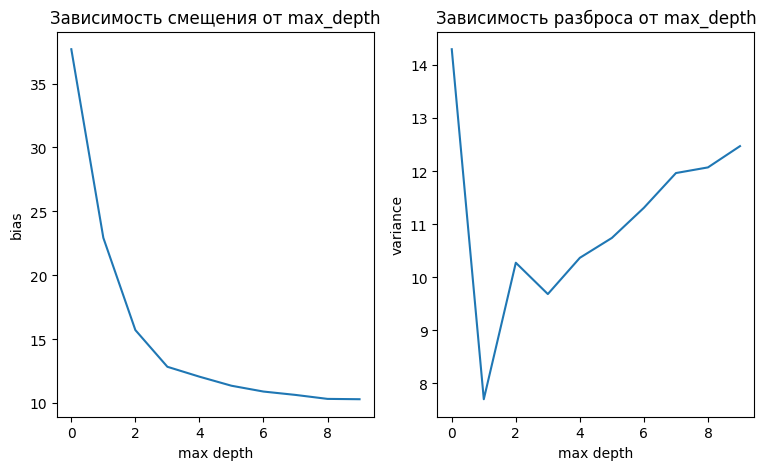

In [150]:
biases = []
variances = []
for max_depth in range(1, 11):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    bias, variance, _ = compute_biase_variance(tree, X, y)
    biases.append(bias)
    variances.append(variance)
fig, ax = plt.subplots(1, 2, figsize = (9, 5))
sns.lineplot(biases, ax = ax[0])
sns.lineplot(variances, ax = ax[1])
ax[0].set_title("Зависимость смещения от max_depth")
ax[1].set_title("Зависимость разброса от max_depth")
ax[0].set_xlabel('max depth')
ax[0].set_ylabel('bias')
ax[1].set_xlabel('max depth')
ax[1].set_ylabel('variance')

plt.show()

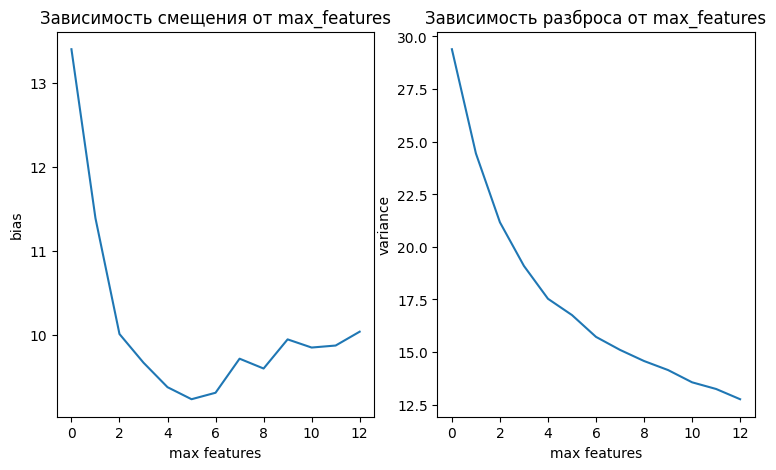

In [152]:
biases = []
variances = []
for max_features in range(1, X.shape[1] + 1):
    tree = DecisionTreeRegressor(max_features=max_features)
    bias, variance, _ = compute_biase_variance(tree, X, y)
    biases.append(bias)
    variances.append(variance)
fig, ax = plt.subplots(1, 2, figsize = (9, 5))
sns.lineplot(biases, ax = ax[0])
sns.lineplot(variances, ax = ax[1])
ax[0].set_title("Зависимость смещения от max_features")
ax[1].set_title("Зависимость разброса от max_features")
ax[0].set_xlabel('max features')
ax[0].set_ylabel('bias')
ax[1].set_xlabel('max features')
ax[1].set_ylabel('variance')

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

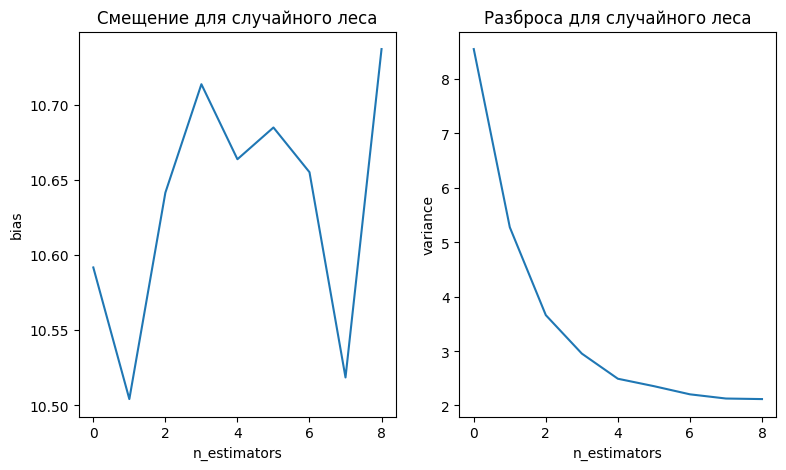

In [156]:
biases = []
variances = []
possible_est = 2**np.arange(1, 10)
for n_estimators in possible_est:
    forest = RandomForestRegressor(n_estimators=n_estimators)
    bias, variance, _ = compute_biase_variance(forest, X, y)
    biases.append(bias)
    variances.append(variance)

fig, ax = plt.subplots(1, 2, figsize = (9, 5))
sns.lineplot(biases, ax = ax[0])
sns.lineplot(variances, ax = ax[1])
ax[0].set_title("Смещение для случайного леса")
ax[1].set_title("Разброса для случайного леса")
ax[0].set_xlabel('n_estimators')
ax[0].set_ylabel('bias')
ax[1].set_xlabel('n_estimators')
ax[1].set_ylabel('variance')

plt.show()

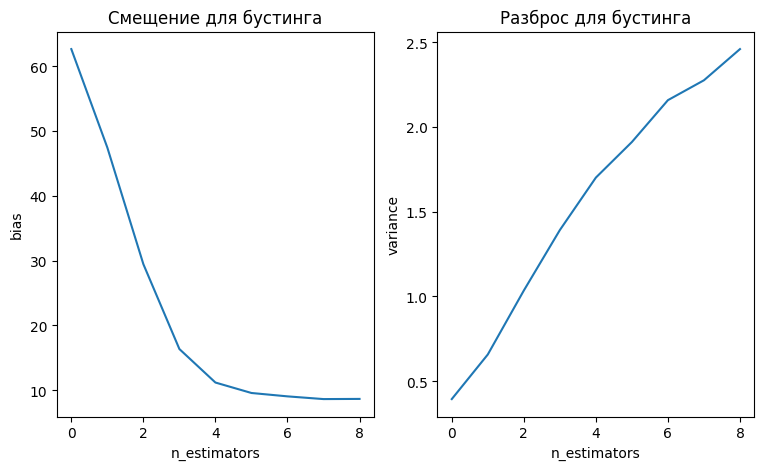

In [157]:
biases = []
variances = []
possible_est = 2**np.arange(1, 10)
for n_estimators in possible_est:
    boosting = GradientBoostingRegressor(n_estimators=n_estimators)
    bias, variance, _ = compute_biase_variance(boosting, X, y)
    biases.append(bias)
    variances.append(variance)

fig, ax = plt.subplots(1, 2, figsize = (9, 5))
sns.lineplot(biases, ax = ax[0])
sns.lineplot(variances, ax = ax[1])
ax[0].set_title("Смещение для бустинга")
ax[1].set_title("Разброс для бустинга")
ax[0].set_xlabel('n_estimators')
ax[0].set_ylabel('bias')
ax[1].set_xlabel('n_estimators')
ax[1].set_ylabel('variance')

plt.show()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

С ростом глубины смещение уменьшается, что согласуется с лекциями, потому что деревья становятся переобученными и очень хорошо подгоняются под обучающую выборку. Разброс же до какого-то момента падает, а потом начинает расти, потому что случается переобучение и дерево становится очень чувствительным к данным.

С ростом числа признаков в дереве смещение сначала падает, а потом выходит на асимптоту, а разброс равномерно падает. Это связано с тем, что когда мы добавляем больше признаков, эффект переобучения становится меньше, поэтому дерево становится менее чувствительным к обучающей выборке.

Для случайного леса при добавлении новых моделей разброс уменьшается, что верно теории, а смещение шатается около одного значения, смещения базовой модели, что тоже верно теории.

Для градиентного бустинга с ростом числов моделей смещение уменьшается, потому что мы пытаемся уменьшить ошибку каждый раз, когда добавляем новую модель, но при этом в какой-то момент наступает переобучение, о чем говорит рост раброса.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

<img src="IMG_5812.JPG">